In [1]:
%matplotlib inline
from curveball.models import *
from scipy.integrate import odeint
import numpy as np
import pandas as pd
import scipy
from lmfit import Model
from lmfit.model import ModelFit
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.2)

In [2]:
def logistic_ode(y, t, r, K, nu, q0, v):
    return r * y * (1 - y/K)


def richards_ode(y, t, r, K, nu, q0, v):
    return r * y * (1 - (y/K)**nu)


def baranyi_roberts_ode(y, t, r, K, nu, q0, v):
    alfa = q0 / (q0 + np.exp(-v * t))
    return alfa * r * y * (1 - (y/K)**nu)


def compare_curves(y1, y2):
    return (abs(y1 - y2) / y1).mean()

In [3]:
t = np.linspace(0, 12, 100)
y0 = 0.1
r = 0.75
K = 1.
nu = 5.
q0 = 0.1
v = 1.0
noise = 0.05
reps = 30

In [4]:
def make_df(func_ode):
    y = odeint(func_ode, y0, t, args=(r, K, nu, q0, v))
    y.resize((len(t),))
    y += np.random.normal(0, noise, len(t))
    y[y<=0] = 0
    df = pd.DataFrame({'OD':y, 'Time': t})
    return df

In [5]:
def fit(df, expected_model, expected_nvarys):
    models,fig,ax = fit_model(df, PLOT=True, PRINT=False)
    return models

y0 0.1 r 0.75 K 1.0 nu 5.0


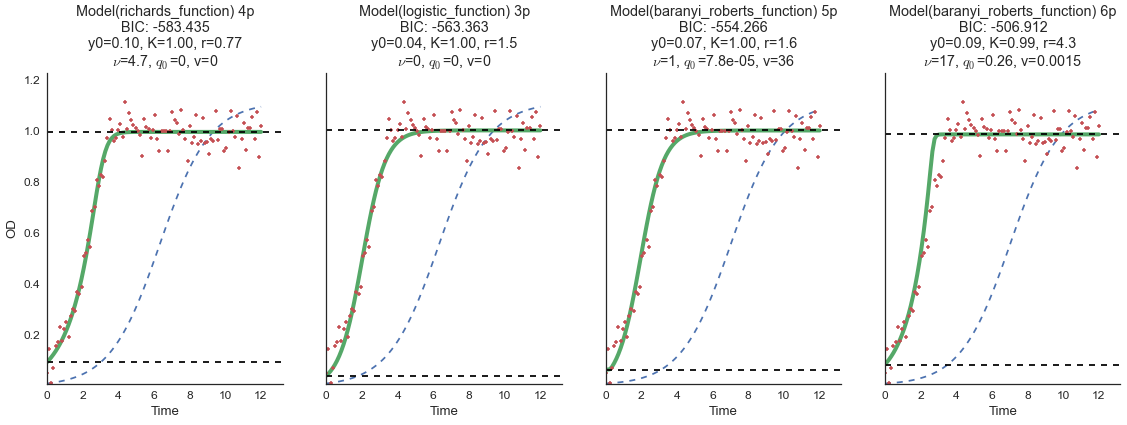

In [6]:
print "y0",y0,"r",r,"K",K,"nu",nu
df = make_df(richards_ode)
models = fit(df, richards_model, 4)
model_fit = models[0]

In [7]:
names = [p.name for p in model_fit.params.values() if p.vary]
means = [p.value for p in model_fit.params.values() if p.vary]
stds  = [p.stderr for p in model_fit.params.values() if p.vary]
cov = np.diag(stds)
cov = model_fit.covar

In [8]:
nsamples = 1000

param_samples = np.random.multivariate_normal(means, cov, nsamples)
param_samples = pd.DataFrame(param_samples, columns=names)
param_samples.head()

,y0,r,K,nu
0,0.095291,0.750018,1.000817,5.165057
1,0.089704,0.790185,1.005213,4.409825
2,0.087286,0.768195,0.995764,7.005832
3,0.115305,0.638035,1.005965,7.023867
4,0.103152,0.737257,1.004850,4.935205


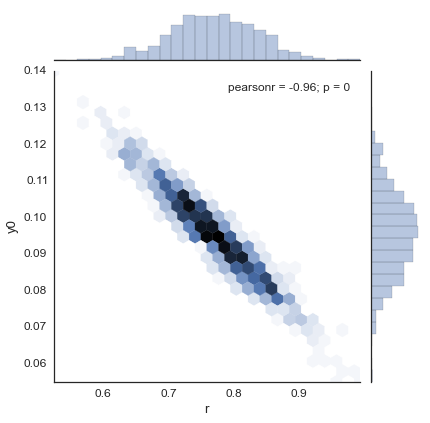

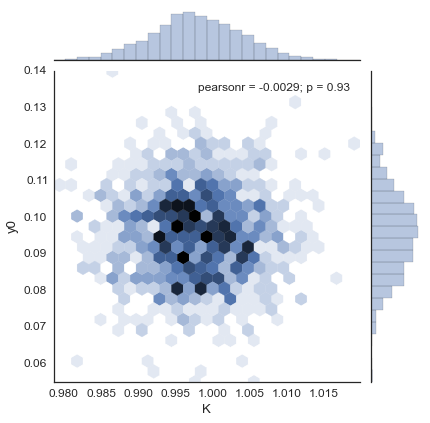

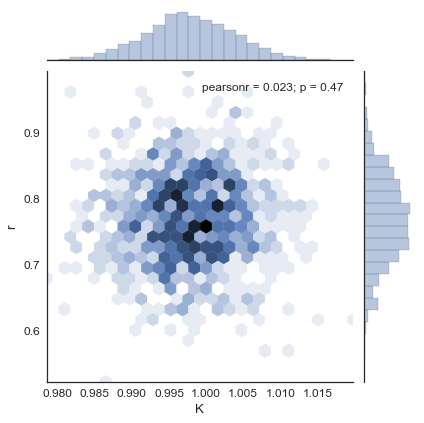

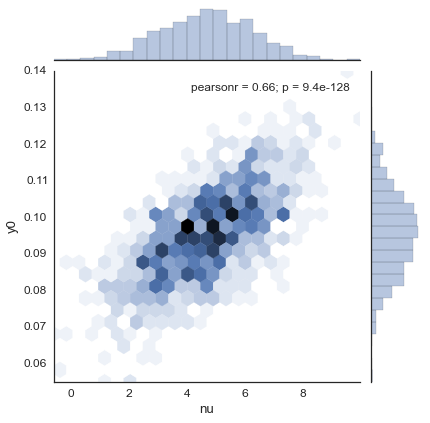

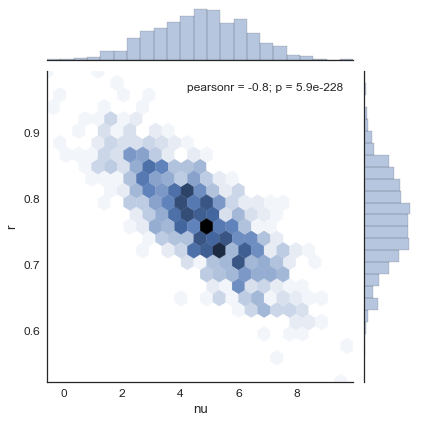

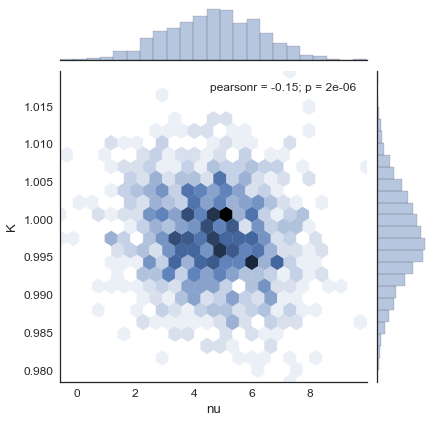

In [9]:
for i1,pname1 in enumerate(names):
    for i2,pname2 in enumerate(names[:i1]):        
        sns.jointplot(x=pname1, y=pname2, data=param_samples, kind='hex')

In [10]:
t=model_fit.userkws['t']
y = np.zeros((len(t),nsamples))
for i in range(nsamples):
    y0,r,K,nu = param_samples.loc[i]
    y[:,i] = model_fit.model.func(t=t, y0=y0, r=r, K=K, nu=nu)

In [11]:
meany = np.nanmean(y, axis=1)
stdy = np.nanstd(y, axis=1, ddof=1) 
ci_low, ci_high = scipy.stats.norm.interval(0.99, loc=meany, scale=stdy)
assert np.isfinite(ci_low).all()
assert np.isfinite(ci_high).all()

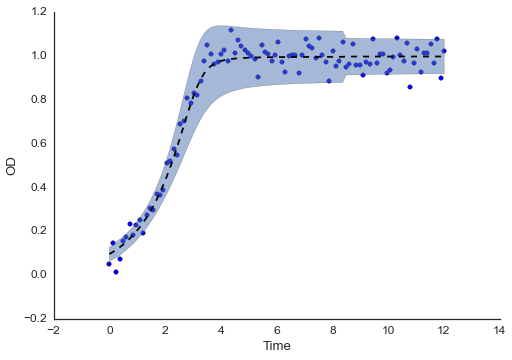

In [12]:
plt.scatter(t, model_fit.data, marker='o')
plt.plot(t, meany, '--k')
plt.fill_between(t, ci_low, ci_high, alpha=0.5)
plt.xlabel('Time')
plt.ylabel('OD')
sns.despine()